<a href="https://colab.research.google.com/github/deepshikharbhardwaj/Machine_Learning/blob/main/ConvolutionalAutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
trainset = datasets.CIFAR10(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Conv_CIFAR10_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, name)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=3, out_channels=8, kernel_size=3
        )
        self.enc2 = nn.Conv2d(
            in_channels=8, out_channels=4, kernel_size=3
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=4, out_channels=8, kernel_size=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=8, out_channels=3, kernel_size=3
        )
    def forward(self, x):
       x = F.relu(self.enc1(x))
       x = F.relu(self.enc2(x))
       x = F.relu(self.dec1(x))
       x = F.relu(self.dec2(x))
       return x
net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(1, 1))
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [8]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            img, _ = data # no need for the labels
            img = img.to(device)
            optimizer.zero_grad()
            outputs = net(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))
        if epoch % 5 == 0:
            save_decoded_image(img.cpu().data, name='./Conv_CIFAR10_Images/original{}.png'.format(epoch))
            save_decoded_image(outputs.cpu().data, name='./Conv_CIFAR10_Images/decoded{}.png'.format(epoch))
    return train_loss

    
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        img = img.to(device)
        outputs = net(img)
        outputs = outputs.view(outputs.size(0), 3, 32, 32).cpu().data
        save_image(outputs, 'conv_cifar10_reconstruction.png')
        break

cpu
Epoch 1 of 50, Train Loss: 0.154
Epoch 2 of 50, Train Loss: 0.146
Epoch 3 of 50, Train Loss: 0.146
Epoch 4 of 50, Train Loss: 0.145
Epoch 5 of 50, Train Loss: 0.145
Epoch 6 of 50, Train Loss: 0.145
Epoch 7 of 50, Train Loss: 0.145
Epoch 8 of 50, Train Loss: 0.145
Epoch 9 of 50, Train Loss: 0.144
Epoch 10 of 50, Train Loss: 0.144
Epoch 11 of 50, Train Loss: 0.144
Epoch 12 of 50, Train Loss: 0.144
Epoch 13 of 50, Train Loss: 0.144
Epoch 14 of 50, Train Loss: 0.144
Epoch 15 of 50, Train Loss: 0.144
Epoch 16 of 50, Train Loss: 0.144
Epoch 17 of 50, Train Loss: 0.143
Epoch 18 of 50, Train Loss: 0.143
Epoch 19 of 50, Train Loss: 0.143
Epoch 20 of 50, Train Loss: 0.143
Epoch 21 of 50, Train Loss: 0.143
Epoch 22 of 50, Train Loss: 0.143
Epoch 23 of 50, Train Loss: 0.143
Epoch 24 of 50, Train Loss: 0.143
Epoch 25 of 50, Train Loss: 0.143
Epoch 26 of 50, Train Loss: 0.143
Epoch 27 of 50, Train Loss: 0.143
Epoch 28 of 50, Train Loss: 0.143
Epoch 29 of 50, Train Loss: 0.143
Epoch 30 of 50, Tra

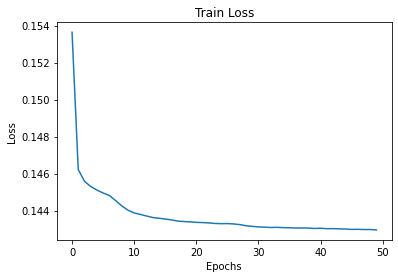

In [9]:
device = get_device()
print(device)
net.to(device)
make_dir()
train_loss = train(net, trainloader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('conv_ae_cifar10_loss.png')
test_image_reconstruction(net, testloader)